In [1]:
import pandas as pd
df_train = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_train.csv")  
df_test = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_test.csv")  
df_valid = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_valid.csv")

# 新数据预处理

In [90]:

import numpy as np
import pandas as pd
from typing import Tuple, List, Dict, Optional
from sklearn.preprocessing import LabelEncoder

# 固定特征列（与项目对齐）
REQ_FEATURES = [
    "timestamp",         # 连续值，后续会做相对化
    "processId",         # 连续/整数
    "parentProcessId",   # 连续/整数
    "userId",            # 连续/整数
    "mountNamespace",    # 连续/整数/类别
    "processName",       # 类别
    "hostName",          # 类别
    "eventName",         # 类别
    "argsNum",           # 连续/计数
    "returnValue",       # 连续/整数
    "stack_depth"        # 由 stackAddresses 衍生
]

CATEGORICAL_COLS = ["processName", "hostName", "eventName"]

def compute_stack_depth(df: pd.DataFrame) -> pd.Series:
    if "stack_depth" in df.columns:
        return df["stack_depth"]
    if "stackAddresses" in df.columns:
        # stackAddresses 可能是字符串 "[]" 或 list
        def _len_safe(x):
            if isinstance(x, list):
                return len(x)
            if isinstance(x, str):
                if x.strip() == "" or x.strip() == "[]":
                    return 0
                # 粗略判断逗号个数
                return x.count(",") + 1 if "[" in x and "]" in x else 0
            return 0
        return df["stackAddresses"].apply(_len_safe).astype("int64")
    # 都没有时，补 0
    return pd.Series(0, index=df.index, dtype="int64")

def make_timestamp_relative(df: pd.DataFrame) -> pd.Series:
    # 按 processId 分组：timestamp - min(timestamp)
    if "timestamp" not in df.columns or "processId" not in df.columns:
        return df.get("timestamp", pd.Series(0.0, index=df.index))
    ts = df["timestamp"].astype("float64")
    pid = df["processId"]
    rel = ts - ts.groupby(pid).transform("min")
    return rel

def basic_clean(df: pd.DataFrame, process_args: bool = False, drop_raw_cols: bool = True) -> pd.DataFrame:
    df = df.copy()
    # 衍生 stack_depth
    df["stack_depth"] = compute_stack_depth(df)
    # timestamp 相对化
    if "timestamp" in df.columns:
        df["timestamp"] = make_timestamp_relative(df)
    # argsNum 尽量保证存在
    if "argsNum" not in df.columns and "args" in df.columns:
        def _len_args(a):
            if isinstance(a, list):
                return len(a)
            if isinstance(a, str):
                return a.count("name") if "name" in a else 0
            return 0
        try:
            df["argsNum"] = df["args"].apply(lambda x: len(x) if isinstance(x, list) else 0)
        except Exception:
            df["argsNum"] = 0

    # 可选：删除大字段
    if drop_raw_cols:
        for col in ["args", "stackAddresses"]:
            if col in df.columns:
                del df[col]
    return df

def ensure_req_features(df: pd.DataFrame) -> pd.DataFrame:
    # 缺失列补 NaN / 0；类型尽量转为数值/字符串
    out = df.copy()
    if "stack_depth" not in out.columns:
        out["stack_depth"] = 0
    for c in REQ_FEATURES:
        if c not in out.columns:
            out[c] = np.nan
    # 类型标准化
    for c in ["processId", "parentProcessId", "userId", "mountNamespace", "argsNum", "returnValue", "stack_depth"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    for c in ["processName", "hostName", "eventName"]:
        if c in out.columns:
            out[c] = out[c].astype(str)
    return out[REQ_FEATURES]

def fit_label_encoders(df_list: List[pd.DataFrame], cat_cols: List[str]) -> Dict[str, LabelEncoder]:
    encoders = {}
    for c in cat_cols:
        le = LabelEncoder()
        # 合并拟合，避免验证/测试集出现未知值
        vals = pd.concat([d[c].astype(str) for d in df_list if c in d.columns], axis=0)
        le.fit(vals.fillna(""))
        encoders[c] = le
    return encoders

def apply_label_encoders(df: pd.DataFrame, encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    df = df.copy()
    for c, le in encoders.items():
        if c in df.columns:
            df[c] = le.transform(df[c].astype(str).fillna(""))
    return df

def z01(scores: np.ndarray, method: str = "minmax") -> np.ndarray:
    s = np.asarray(scores, dtype=float)
    if method == "minmax":
        lo, hi = np.nanmin(s), np.nanmax(s)
        if hi - lo < 1e-12:
            return np.zeros_like(s)
        return (s - lo) / (hi - lo)
    elif method == "rank":
        # 分位数映射到 [0,1]
        ranks = pd.Series(s).rank(method="average") / len(s)
        return ranks.to_numpy()
    else:
        raise ValueError("Unknown norm method")

def choose_id_column(df: pd.DataFrame, candidates: List[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    # 兜底：保存一个 index 列
    return None

# 基础清洗
train_df = basic_clean(df_train, process_args=False, drop_raw_cols=True)
valid_df = basic_clean(df_valid, process_args=False, drop_raw_cols=True)
test_df  = None if df_test is None else basic_clean(df_test, process_args=False, drop_raw_cols=True)

# 对齐必需特征
train_df = ensure_req_features(train_df)
valid_df = ensure_req_features(valid_df)
if test_df is not None:
    test_df = ensure_req_features(test_df)

# 类别编码（使用 训练+验证+测试 的并集拟合）
enc_fit_list = [train_df, valid_df] + ([test_df] if test_df is not None else [])
encoders = fit_label_encoders(enc_fit_list, CATEGORICAL_COLS)
train_enc = apply_label_encoders(train_df, encoders)
valid_enc = apply_label_encoders(valid_df, encoders)
test_enc  = None if test_df is None else apply_label_encoders(test_df, encoders)

print('Train shape:', train_enc.shape)
print('Valid shape:', valid_enc.shape)
if test_enc is not None:
    print('Test shape:', test_enc.shape)

train_enc.head(3)


Train shape: (638720, 11)
Valid shape: (102160, 11)
Test shape: (259293, 11)


,timestamp,processId,parentProcessId,userId,mountNamespace,processName,hostName,eventName,argsNum,returnValue,stack_depth
0,0.000000,381,1,101,4026532232,91,0,40,3,15,3
1,0.000000,1,0,0,4026531840,86,0,32,4,0,2
2,0.000079,1,0,0,4026531840,86,0,17,2,0,1


# 新数据处理重构

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Tuple
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------------
# 目标最终特征列（固定顺序，一共 11 个）
# --------------------------------------------------
FINAL_FEATURES = [
    "timestamp",         # 相对化时间戳（按 processId）
    "processId",
    "parentProcessId",
    "userId",
    "mountNamespace",
    "stack_depth",       # 由 stackAddresses 推出来
    "processName",       # 类别 -> 会做LabelEncoder
    "hostName",          # 类别 -> 会做LabelEncoder
    "eventName",         # 类别 -> 会做LabelEncoder
    "argsNum",           # 数值/计数
    "returnValue",       # 数值/整数
]

CATEGORICAL_COLS = ["processName", "hostName", "eventName"]  # 需要做LabelEncoder的列


# --------------------------------------------------
# 1) 每一列各自的处理函数
# --------------------------------------------------

def process_timestamp(df: pd.DataFrame) -> pd.Series:
    """
    timestamp 相对化：timestamp - group_min(timestamp) 其中分组是 processId
    如果缺列，补 0.0
    """
    if "timestamp" not in df.columns:
        return pd.Series(0.0, index=df.index, name="timestamp")

    ts = pd.to_numeric(df["timestamp"], errors="coerce").astype("float64")

    if "processId" in df.columns:
        rel = ts - ts.groupby(df["processId"]).transform("min")
        return rel.rename("timestamp")

    # 没有 processId 就只能原样数值化
    return ts.rename("timestamp")


def process_processId(df: pd.DataFrame) -> pd.Series:
    s = pd.to_numeric(df.get("processId", np.nan), errors="coerce")
    return pd.Series(s, index=df.index, name="processId")


def process_parentProcessId(df: pd.DataFrame) -> pd.Series:
    s = pd.to_numeric(df.get("parentProcessId", np.nan), errors="coerce")
    return pd.Series(s, index=df.index, name="parentProcessId")


def process_userId(df: pd.DataFrame) -> pd.Series:
    s = pd.to_numeric(df.get("userId", np.nan), errors="coerce")
    return pd.Series(s, index=df.index, name="userId")


def process_mountNamespace(df: pd.DataFrame) -> pd.Series:
    s = pd.to_numeric(df.get("mountNamespace", np.nan), errors="coerce")
    return pd.Series(s, index=df.index, name="mountNamespace")


def process_stack_depth(df: pd.DataFrame) -> pd.Series:
    """
    规则：
    - 如果已有 stack_depth 直接拿
    - 否则根据 stackAddresses 算长度
      - list -> len(list)
      - 字符串 "[]" 或空 -> 0
      - 字符串 "[a,b,c]" -> 用逗号数+1 估个长度
    - 都没有则全 0
    """
    if "stack_depth" in df.columns:
        return (
            pd.to_numeric(df["stack_depth"], errors="coerce")
            .fillna(0)
            .astype("int64")
            .rename("stack_depth")
        )

    if "stackAddresses" in df.columns:
        def _len_safe(x):
            if isinstance(x, list):
                return len(x)
            if isinstance(x, str):
                xs = x.strip()
                if xs == "" or xs == "[]":
                    return 0
                # 估计回溯深度：逗号数量+1（仅当像"[...]"这种格式）
                return (xs.count(",") + 1) if ("[" in xs and "]" in xs) else 0
            return 0

        return (
            df["stackAddresses"]
            .apply(_len_safe)
            .astype("int64")
            .rename("stack_depth")
        )

    return pd.Series(0, index=df.index, name="stack_depth", dtype="int64")


def process_processName(df: pd.DataFrame) -> pd.Series:
    s = df.get("processName", pd.Series("", index=df.index))
    return s.astype(str).fillna("").rename("processName")


def process_hostName(df: pd.DataFrame) -> pd.Series:
    s = df.get("hostName", pd.Series("", index=df.index))
    return s.astype(str).fillna("").rename("hostName")


def process_eventName(df: pd.DataFrame) -> pd.Series:
    s = df.get("eventName", pd.Series("", index=df.index))
    return s.astype(str).fillna("").rename("eventName")


def process_argsNum(df: pd.DataFrame) -> pd.Series:
    """
    优先使用现成 argsNum。
    否则尝试从 args 衍生：
    - list -> len(list)
    - 字符串里如果包含 "name" 多次，就用出现次数当作参数个数（近似）
    - 否则用逗号估计 "[...,...,...]" -> 逗号数+1
    都没有则 0
    """
    if "argsNum" in df.columns:
        return (
            pd.to_numeric(df["argsNum"], errors="coerce")
            .fillna(0)
            .rename("argsNum")
        )

    if "args" in df.columns:
        def _len_args(a):
            if isinstance(a, list):
                return len(a)
            if isinstance(a, str):
                xs = a.strip()
                if xs == "" or xs == "[]":
                    return 0
                if "name" in xs:
                    return xs.count('"name"')
                return (xs.count(",") + 1) if ("[" in xs and "]" in xs) else 0
            return 0

        return (
            df["args"]
            .apply(_len_args)
            .astype("int64")
            .rename("argsNum")
        )

    return pd.Series(0, index=df.index, name="argsNum", dtype="int64")


def process_returnValue(df: pd.DataFrame) -> pd.Series:
    s = pd.to_numeric(df.get("returnValue", np.nan), errors="coerce")
    return pd.Series(s, index=df.index, name="returnValue")


# --------------------------------------------------
# 2) 把所有单列拼成一个特征表（11列齐全）
# --------------------------------------------------

def assemble_feature_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    逐列调用上面的处理函数，按 FINAL_FEATURES 顺序拼接成特征矩阵。
    """
    cols = [
        process_timestamp(df),
        process_processId(df),
        process_parentProcessId(df),
        process_userId(df),
        process_mountNamespace(df),
        process_stack_depth(df),
        process_processName(df),
        process_hostName(df),
        process_eventName(df),
        process_argsNum(df),
        process_returnValue(df),
    ]
    out = pd.concat(cols, axis=1)

    # 强制列顺序，防止 concat 时乱序
    out = out[FINAL_FEATURES]

    return out


# --------------------------------------------------
# 3) LabelEncoder 部分：只对那 3 个类别列做
# --------------------------------------------------

def fit_label_encoders(df_list: List[pd.DataFrame]) -> Dict[str, LabelEncoder]:
    """
    从 train/valid/test 的并集中拟合 encoder，
    避免测试集出现新字符串时报错。
    """
    encoders: Dict[str, LabelEncoder] = {}

    for col in CATEGORICAL_COLS:
        merged_vals = []
        for d in df_list:
            if d is not None and col in d.columns:
                merged_vals.append(d[col].astype(str).fillna(""))

        if not merged_vals:
            # 所有 df 都没有这一列就跳过
            continue

        all_vals = pd.concat(merged_vals, axis=0)
        le = LabelEncoder()
        le.fit(all_vals)
        encoders[col] = le

    return encoders


def apply_label_encoders(df: pd.DataFrame, encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    """
    返回一个副本；如果某列不在 encoders 里，就保持原样。
    """
    out = df.copy()
    for col, le in encoders.items():
        if col in out.columns:
            out[col] = le.transform(out[col].astype(str).fillna(""))
    return out


# --------------------------------------------------
# 4) 端到端流水线
# --------------------------------------------------

def fe_pipeline(
    df_train: pd.DataFrame,
    df_valid: pd.DataFrame,
    df_test: Optional[pd.DataFrame] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Dict[str, LabelEncoder]]:
    """
    返回:
      train_feat_enc, valid_feat_enc, test_feat_enc, encoders

    步骤：
      1. 对每个 df 单独跑 assemble_feature_table()，得到 11 列
      2. 用 train+valid(+test) 拟合三个类别列的 LabelEncoder
      3. 把 encoder 应用回去
    """
    train_feat = assemble_feature_table(df_train)
    valid_feat = assemble_feature_table(df_valid)
    test_feat  = assemble_feature_table(df_test) if df_test is not None else None

    encoders = fit_label_encoders([train_feat, valid_feat, test_feat])

    train_enc = apply_label_encoders(train_feat, encoders)
    valid_enc = apply_label_encoders(valid_feat, encoders)
    test_enc  = apply_label_encoders(test_feat, encoders) if test_feat is not None else None

    return train_enc, valid_enc, test_enc, encoders


# --------------------------------------------------
# 5) 使用方式示例（放在你的训练脚本里）
# --------------------------------------------------
train_enc, valid_enc, test_enc, encoders = fe_pipeline(df_train, df_valid, df_test)
print("Train shape:", train_enc.shape)   # (N_train, 11)
print("Valid shape:", valid_enc.shape)   # (N_valid, 11)
if test_enc is not None:
    print("Test shape:", test_enc.shape) # (N_test, 11)
print(train_enc.head(3))


Train shape: (638720, 11)
Valid shape: (102160, 11)
Test shape: (259293, 11)
   timestamp  processId  parentProcessId  userId  mountNamespace  stack_depth  \
0   0.000000        381                1     101      4026532232            3   
1   0.000000          1                0       0      4026531840            2   
2   0.000079          1                0       0      4026531840            1   

   processName  hostName  eventName  argsNum  returnValue  
0           91         0         40        3           15  
1           86         0         32        4            0  
2           86         0         17        2            0  


# 旧数据预处理

In [91]:
# ======================================================
# FeatureEngineering_simple.py
# Modular preprocessing for BETH dataset (IsolationForest friendly)
# ======================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction import FeatureHasher

# ------------------------------------------------------
# 1️⃣  单特征处理函数
# ------------------------------------------------------

def process_userId(df: pd.DataFrame) -> pd.Series:
    """userId: 二值化 + 保留外来账号强度"""
    if 'userId' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['userId']
    flag = (s >= 1000).astype(int)
    strength = np.where(s >= 1000, np.log1p(s - 999), 0)
    return pd.Series(flag, name="userId_flag"), pd.Series(strength, name="userId_log_strength")

def process_argsNum(df: pd.DataFrame) -> pd.Series:
    """argsNum: 对数变换"""
    if 'argsNum' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['argsNum'].fillna(0)
    return pd.Series(np.log1p(s), name="argsNum_log")

def process_stackAddresses(df: pd.DataFrame) -> pd.Series:
    """stackAddresses: 栈深度（健壮解析 list/tuple/str）"""
    if 'stackAddresses' not in df.columns:
        return pd.Series(0, index=df.index)
    def count_depth(x):
        if isinstance(x, (list, tuple)):
            return len(x)
        if isinstance(x, str):
            s = x.strip()
            if not s:
                return 0
            seps = ['|', ',', ';']
            for sep in seps:
                if sep in s:
                    parts = [p for p in s.split(sep) if p]
                    return len(parts)
            return len(s.split())
        return 0
    depth = df['stackAddresses'].apply(count_depth)
    return pd.Series(np.log1p(depth), name="stack_depth_log")


def process_parentProcessId(df: pd.DataFrame) -> pd.Series:
    """parentProcessId: 是否为系统级(0,1,2)"""
    if 'parentProcessId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['parentProcessId'].isin([0,1,2]).astype(int), name="parentPID_sys_flag")

def process_processId(df: pd.DataFrame) -> pd.Series:
    """processId: 是否为系统级(0,1,2)"""
    if 'processId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['processId'].isin([0,1,2]).astype(int), name="process_sys_flag")

def Wangprocess_someFeature(df: pd.DataFrame) -> pd.DataFrame:
    """
    自定义特征处理（返回 DataFrame，不会引入额外行）
    生成列：
      - eventId
      - argsNum
      - processId_is_os, parentProcessId_is_os, userId_is_os
      - mountNamespace_is_default
      - returnValue_mapped (-1/0/1)
    """
    out = pd.DataFrame(index=df.index)

    # 安全取列（缺失时填 0）
    # out["eventId"] = df["eventId"] if "eventId" in df.columns else 0
    #out["argsNum"] = df["argsNum"] if "argsNum" in df.columns else 0

    if "processId" in df.columns:
        out["processId_is_os"] = df["processId"].isin([0, 1, 2]).astype(int)
    else:
        out["processId_is_os"] = 0

    if "parentProcessId" in df.columns:
        out["parentProcessId_is_os"] = df["parentProcessId"].isin([0, 1, 2]).astype(int)
    else:
        out["parentProcessId_is_os"] = 0

    if "userId" in df.columns:
        out["userId_is_os"] = (df["userId"] < 1000).astype(int)
    else:
        out["userId_is_os"] = 0

    if "mountNamespace" in df.columns:
        out["mountNamespace_is_default"] = (df["mountNamespace"] == 4026531840).astype(int)
    else:
        out["mountNamespace_is_default"] = 0

    if "returnValue" in df.columns:
        rv = pd.to_numeric(df["returnValue"], errors="coerce").fillna(0)
        out["returnValue_mapped"] = np.select(
            [rv < 0, rv == 0, rv > 0],
            [-1, 0, 1],
            default=0
        )
    else:
        out["returnValue_mapped"] = 0

    # 统一数值类型 & 缺失填充
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0)

    # 可选：快速自检，确保行数不变
    # assert out.shape[0] == df.shape[0]

    return out
# ------------------------------------------------------
# 2️⃣  主控制函数
# ------------------------------------------------------

def preprocess(df: pd.DataFrame, n_hash_features: int = 32) -> pd.DataFrame:
    """
    主预处理函数：调用各单独特征函数，并拼接为模型可用 DataFrame。
    """

    feats = []

    # === 数值 / 二值类 ===
    uflag, ulog = process_userId(df)
    feats += [uflag, ulog,
              #process_mountNamespace(df),
              #process_returnValue(df),
              process_argsNum(df),
              process_stackAddresses(df),
              process_parentProcessId(df),
              process_processId(df)
              ]

    # === 自定义特征类 ===
    feats.append(Wangprocess_someFeature(df))


    # 拼接所有结果
    df_out = pd.concat(feats, axis=1)

    # 缺失值统一填 0
    df_out = df_out.fillna(0)

    # 只保留数值
    df_out = df_out.select_dtypes(include=[np.number])

    return df_out



In [92]:
df_train_feat = preprocess(df_train, n_hash_features=32)
df_test_feat = preprocess(df_test, n_hash_features=32)
df_valid_feat = preprocess(df_valid, n_hash_features=32)

c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Softwares\Anaconda\envs\p310cuda12.7\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
df_train_feat.shape

(638720, 11)

In [94]:
df_train_feat.head()
#df_train_feat.head().to_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\df_train_feat_sample.csv", index=False)

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,userId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.386294,1.386294,1,0,0,1,1,0,1
1,0,0.0,1.609438,1.098612,1,1,1,1,1,1,0
2,0,0.0,1.098612,0.693147,1,1,1,1,1,1,0
3,0,0.0,1.609438,1.098612,1,1,1,1,1,1,0
4,0,0.0,1.609438,0.693147,1,1,1,1,1,1,1


In [95]:
df_valid_feat.shape
df_valid_feat.head()

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,userId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.386294,1.386294,1,0,0,1,1,0,1
1,0,0.0,0.693147,0.693147,1,1,1,1,1,1,0
2,0,0.0,1.098612,0.693147,1,0,0,1,1,0,0
3,0,0.0,0.693147,0.693147,1,0,0,1,1,0,0
4,0,0.0,1.609438,0.693147,1,0,0,1,1,0,0


In [96]:
df_test_feat.shape
df_test_feat.head()

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,userId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.098612,0.693147,0,0,0,0,1,1,0
1,0,0.0,0.693147,1.098612,0,0,0,0,1,1,0
2,0,0.0,0.693147,0.693147,1,1,1,1,1,1,0
3,0,0.0,0.693147,0.693147,0,0,0,0,1,1,0
4,0,0.0,1.609438,0.693147,0,0,0,0,1,1,1


In [97]:
# 保存 Id 列
test_ids = df_test["Id"].copy()  
test_ids.head()

0    0
1    1
2    2
3    3
4    4
Name: Id, dtype: int64

# 新、旧数据预处理合并

In [98]:
# train_enc
df_train_feat = pd.concat([train_enc.reset_index(drop=True), df_train_feat.reset_index(drop=True)], axis=1)
df_valid_feat = pd.concat([valid_enc.reset_index(drop=True), df_valid_feat.reset_index(drop=True)], axis=1)
df_test_feat = pd.concat([test_enc.reset_index(drop=True), df_test_feat.reset_index(drop=True)], axis=1)

In [99]:
# df_train_feat.shape
df_train_feat.head().__dict__

{'_is_copy': <weakref at 0x0000017DF3A11620; to 'DataFrame' at 0x0000017DBEC0D660>,
 '_mgr': BlockManager
 Items: Index(['timestamp', 'processId', 'parentProcessId', 'userId', 'mountNamespace',
        'processName', 'hostName', 'eventName', 'argsNum', 'returnValue',
        'stack_depth', 'userId_flag', 'userId_log_strength', 'argsNum_log',
        'stack_depth_log', 'parentPID_sys_flag', 'process_sys_flag',
        'processId_is_os', 'parentProcessId_is_os', 'userId_is_os',
        'mountNamespace_is_default', 'returnValue_mapped'],
       dtype='object')
 Axis 1: RangeIndex(start=0, stop=5, step=1)
 NumpyBlock: slice(0, 1, 1), 1 x 5, dtype: float64
 NumpyBlock: slice(1, 11, 1), 10 x 5, dtype: int64
 NumpyBlock: slice(12, 15, 1), 3 x 5, dtype: float64
 NumpyBlock: [11 15 16 17 18 19 20 21], 8 x 5, dtype: int64,
 '_item_cache': {},
 '_attrs': {},
 '_flags': <Flags(allows_duplicate_labels=True)>}

In [100]:
from sklearn.ensemble import IsolationForest
# model = IsolationForest(
#     n_estimators=100,
#     contamination=0.005,
#     max_features=0.6,
#     max_samples=0.6,
#     random_state=42,
#     n_jobs=-1
# )
model = IsolationForest(
    n_estimators=100,
    contamination=0.015,
    max_features=0.8,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)
# model = IsolationForest(
#     n_estimators=150,
#     contamination=0.04,
#     max_features=1.0,
#     max_samples=20000,
#     random_state=42,
#     n_jobs=-1
# )
model.fit(df_train_feat)

from sklearn.neighbors import LocalOutlierFactor
# ---------- 1) 训练 LOF ----------
# 重要：要在新数据上 predict，必须 novelty=True
# model = LocalOutlierFactor(
#     n_neighbors=35,        # 可调：20~50 常见
#     contamination=0.04,    # 只用于确定训练集阈值/offset
#     novelty=True,          # 允许对 valid/test 预测
#     metric="minkowski", p=2,
#     n_jobs=-1
# )
# print("Fitting LOF...")
# model.fit(df_train_feat)
# print("✅ LOF fitted.")

In [101]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score, precision_recall_fscore_support
# ========== 5. 模型评估 ==========
print("\nMaking predictions on validation data...")
y_valid_target = df_valid['target']

# 异常分数（越大越异常）
scores = -model.decision_function(df_valid_feat)
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
# Average Precision
ap = average_precision_score(y_valid_target, scores_norm)
# 固定 percentile=97 计算 F1、P、R
thr = np.percentile(scores_norm, 97)
y_pred = (scores_norm >= thr).astype(int)
p, r, f1, _ = precision_recall_fscore_support(y_valid_target, y_pred, average="binary")

print("\nModel Evaluation:" + "precision: {:.4f}, recall: {:.4f}, F1-score: {:.4f}, AP: {:.4f}".format(p, r, f1, ap))
#print("Accuracy:", accuracy_score(y_valid_target, y_pred))
#print("\nConfusion Matrix:")
#print(confusion_matrix(y_valid_target, y_pred))
#print("\nClassification Report:")
#print(classification_report(y_valid_target, y_pred, zero_division=0))


Making predictions on validation data...

Model Evaluation:precision: 0.9863, recall: 0.7764, F1-score: 0.8688, AP: 0.9252


# test

In [102]:
# Evaluating combination 1/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.005, 'random_state': 42}
# ========== 5. 模型测试 》》》 输出csv文件，提交kaggle ==========
print("\nMaking predictions on test data...")
# 手动设置阈值 percentile = 0.97
# === 3️⃣ 手动设置阈值 percentile = 97 ===
# === 2️⃣ 计算测试集异常分数 ===
score_test = -model.decision_function(df_test_feat)
# === 2️⃣ 将异常分数归一化到 [0, 1] ===
score_norm = (score_test - score_test.min()) / (score_test.max() - score_test.min())
# === 3️⃣ 构建提交 DataFrame ===
submission = pd.DataFrame({
    "Id": df_test["Id"],   # ⚠️ 必须与你的 processes_test.csv 中的 Id 对应
    "target": score_norm               # Kaggle 要求列名为 target
})

# === 4️⃣ 保存为 CSV 文件（无 index） ===
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv 已生成，可直接上传至 Kaggle！")


Making predictions on test data...
✅ submission.csv 已生成，可直接上传至 Kaggle！


▶ Evaluating combination 1/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.005, 'random_state': 42}
[01/54] n_est=100, samp=0.6, feat=0.6, cont=0.005 → P=0.9834, R=0.7754, F1=0.8671, AP=0.9234
▶ Evaluating combination 2/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.008, 'random_state': 42}
[02/54] n_est=100, samp=0.6, feat=0.6, cont=0.008 → P=0.9834, R=0.7754, F1=0.8671, AP=0.9234
▶ Evaluating combination 3/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.015, 'random_state': 42}
[03/54] n_est=100, samp=0.6, feat=0.6, cont=0.015 → P=0.9834, R=0.7754, F1=0.8671, AP=0.9234
▶ Evaluating combination 4/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.8, 'contamination': 0.005, 'random_state': 42}
[04/54] n_est=100, samp=0.6, feat=0.8, cont=0.005 → P=0.9856, R=0.7756, F1=0.8681, AP=0.9234
▶ Evaluating combination 5/54: {'n_estimators': 100, 'max_samples': 0.6, 'ma

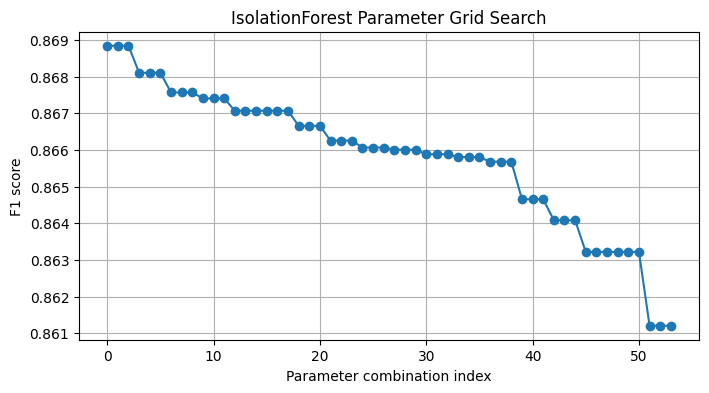

In [104]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    average_precision_score, 
    precision_recall_fscore_support
)
from itertools import product

# =============================
# 参数网格定义
# =============================
param_grid = {
    "n_estimators": [100, 200],
    "max_samples": [0.6, 0.8, 1.0],
    "max_features": [0.6, 0.8, 1.0],
    "contamination": [0.005, 0.008, 0.015],
    "random_state": [42]
}

# 展开网格为组合列表
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# =============================
# 定义评估函数
# =============================
def evaluate_isoforest(params, X_train, X_valid, y_valid, percentile=97):
    """训练 IsolationForest 并返回验证集指标"""
    model = IsolationForest(**params, n_jobs=-1)
    model.fit(X_train)
    
    # 异常分数（越大越异常）
    scores = -model.decision_function(X_valid)
    scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
    
    # 平均精度 AP
    ap = average_precision_score(y_valid, scores_norm)
    
    # 固定分位数阈值，计算 Precision/Recall/F1
    thr = np.percentile(scores_norm, percentile)
    y_pred = (scores_norm >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average="binary")
    
    return {
        "params": params,
        "precision": p,
        "recall": r,
        "f1": f1,
        "ap": ap
    }

# =============================
# 主循环：网格搜索
# =============================
results = []

for i, params in enumerate(param_combinations, 1):
    print(f"▶ Evaluating combination {i}/{len(param_combinations)}: {params}")
    metrics = evaluate_isoforest(params, df_train_feat, df_valid_feat, df_valid["target"])
    results.append(metrics)
    # ✅ 实时打印当前性能
    print(f"[{i:02d}/{len(param_combinations)}] "
          f"n_est={params['n_estimators']}, samp={params['max_samples']}, feat={params['max_features']}, cont={params['contamination']} "
          f"→ P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f}, AP={metrics['ap']:.4f}")

# 转为 DataFrame
results_df = pd.DataFrame(results)

# =============================
# 输出结果
# =============================
results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)

print("\n===== Grid Search Summary =====")
print(results_df[["params", "precision", "recall", "f1", "ap"]])

best_params = results_df.loc[0, "params"]
print("\n✅ Best parameter combination:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# =============================
# 可视化 F1 对比（可选）
# =============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(results_df["f1"].values, marker="o")
plt.xlabel("Parameter combination index")
plt.ylabel("F1 score")
plt.title("IsolationForest Parameter Grid Search")
plt.grid(True)
plt.show()


In [105]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# 统一分数定义：越大越异常
scores = -model.decision_function(df_valid_feat)
y_valid_target = df_valid['target']
ap = average_precision_score(y_valid_target, scores)

prec, rec, thr = precision_recall_curve(y_valid_target, scores)

print(f"AP={ap:.4f},  MaxPrecision@AnyRecall={prec.max():.4f}")

# 看你固定97分位在曲线上的位置
p97 = np.percentile(scores, 97)
yp97 = (scores >= p97).astype(int)
from sklearn.metrics import precision_recall_fscore_support
P,R,F1,_ = precision_recall_fscore_support(y_valid_target, yp97, average="binary")
print(f"@97th → P={P:.4f}, R={R:.4f}, F1={F1:.4f}")


AP=0.9252,  MaxPrecision@AnyRecall=1.0000
@97th → P=0.9863, R=0.7764, F1=0.8688


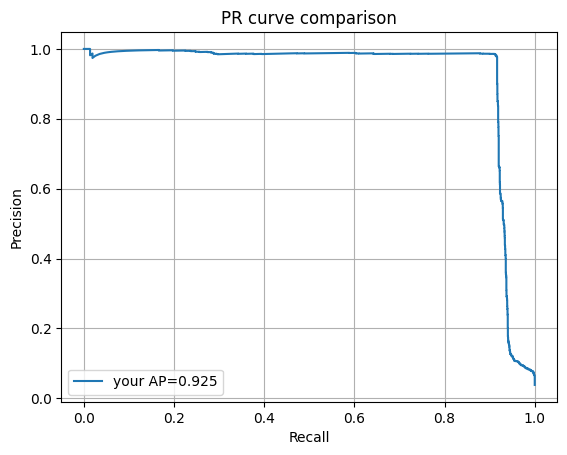

In [106]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# scores1 = -isoModel.decision_function(x_valid)     # 左模型
scores2 = -model.decision_function(df_valid_feat)  # 右模型
y = y_valid_target

# ap1 = average_precision_score(y, scores1)
ap2 = average_precision_score(y, scores2)

# print(f"AP1={ap1:.4f}, AP2={ap2:.4f}")

import matplotlib.pyplot as plt
# prec1, rec1, _ = precision_recall_curve(y, scores1)
prec2, rec2, _ = precision_recall_curve(y, scores2)
# plt.plot(rec1, prec1, label=f'ipynb AP={ap1:.3f}')
plt.plot(rec2, prec2, label=f'your AP={ap2:.3f}')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True)
plt.title("PR curve comparison")
plt.show()

# ISO + RF 集成